In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
from pylab import *
import scipy.io
import scipy.signal
import scipy.fftpack
from scipy.signal import butter, lfilter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, \
BatchNormalization, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import statistics 

# **Import data from files**

In [2]:
filepath = "C:\\Users\\Nikolas Theol\\Desktop\\ECE\\Διπλωματικη\\Spindles"
edf_file = "excerpt6.txt"
total_filepath = filepath + "\\" + edf_file
raw = pd.read_csv(total_filepath, sep='\n')
    
spindle_marks1 = "Automatic_detection_excerpt6.txt"
#spindle_marks2 = input("Enter name of the .txt file containing the detected spindles: ")

temp1 = filepath + "\\" + spindle_marks1
expert_spindles1 = pd.read_csv(temp1, sep='\t').reset_index()
expert_spindles1.columns = ['time', 'duration']

#temp2 = filepath + "\\" + spindle_marks2
#expert_spindles2 = pd.read_csv(temp2, sep='\t').reset_index()
#expert_spindles2.columns = ['time', 'duration']

## Butter Bandpass Filter

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# **Enter sampling frequency**

In [4]:
raw = np.array(raw).flatten().T
total_samples = len(raw)
sampling_freq = 200
sampling_freq = int(sampling_freq)

# **Plot the EEG Recording**

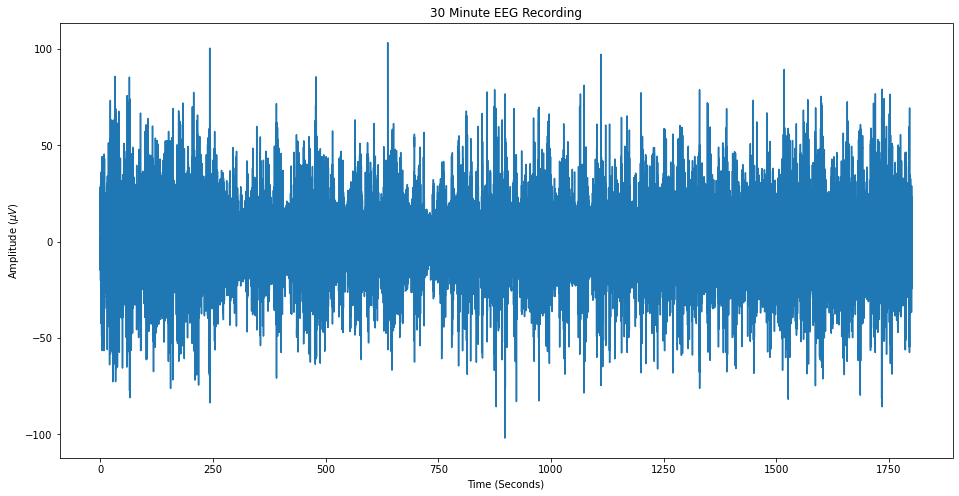

In [5]:
y = butter_bandpass_filter(raw, 1, 30, sampling_freq, order=6)

%matplotlib inline

fig = plt.figure(figsize=(16,8))

max_time = total_samples / sampling_freq
t = np.arange(0, max_time, 1/sampling_freq)

plt.xlabel("Time (Seconds)")
plt.ylabel("Amplitude ($\mu V$)")
plt.title("30 Minute EEG Recording")
plt.plot(t, y)

plt.show()



# Normilization

In [6]:
mean = statistics.mean(y)
stdev = statistics.stdev(y)
for i in range(len(y)):
    y[i] = (y[i]-mean)/stdev

# **Create dataframe for spindle events**
* start of spindle
* end of spindle

In [7]:
microevents_start = (np.array(expert_spindles1['time']) * 100).astype(int)
microevents_duration = (np.array(expert_spindles1['duration']) * 100).astype(int)
microevents_end = np.sum([microevents_start, microevents_duration], axis=0)

d = {'start':microevents_start, 'end':microevents_end}
spindle_events1 = pd.DataFrame(data=d)
spindle_events1 = spindle_events1.values

In [8]:
#microevents_start = (np.array(expert_spindles2['time'])*100).astype(int)
#microevents_duration = (np.array(expert_spindles2['duration']) * 100).astype(int)
#microevents_end = np.sum([microevents_start, microevents_duration], axis=0)

#d = {'start':microevents_start, 'end':microevents_end}
#spindle_events2 = pd.DataFrame(data=d)
#spindle_events2 = spindle_events2.values

# **Plot EEG recording with spindle annotation**

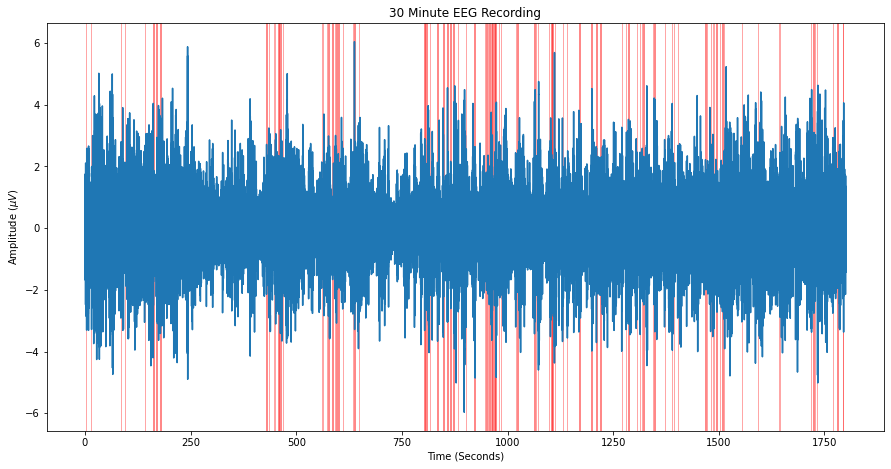

In [9]:
ig = plt.figure(figsize=(15,7.5))

max_time = total_samples / sampling_freq
t = np.arange(0, max_time, 1/sampling_freq)

plt.xlabel("Time (Seconds)")
plt.ylabel("Amplitude ($\mu V$)")
plt.title("30 Minute EEG Recording")
plt.plot(t, y)

for event in np.arange(len(spindle_events1)):
    plt.axvspan(spindle_events1[event][0]/100, spindle_events1[event][1]/100, alpha=0.35, color='red')  

#for event in np.arange(len(spindle_events2)):
#    plt.axvspan(spindle_events2[event][0]/100, spindle_events2[event][1]/100, alpha=0.35, color='green')  
    
plt.show()



# **Create dataframe of raw data including the time values**

In [10]:
data = pd.DataFrame(data = y)
time = []
temp = 0
for i in range(360140):  
    time.insert(i,temp)
    temp = temp + 0.005

In [11]:
data['time'] = time
data.columns = ['μV', 'time']

In [12]:
data

,μV,time
0,-0.001052,0.000
1,-0.009847,0.005
2,-0.044260,0.010
3,-0.126926,0.015
4,-0.263723,0.020
...,...,...
360135,0.810323,1800.675
360136,0.653917,1800.680
360137,0.432062,1800.685
360138,0.122264,1800.690


# **Annotate values**

* 1 for spindle
* 0 for non-spindle

In [13]:
microevents_start = expert_spindles1['time']
microevents_duration = expert_spindles1['duration']
microevents_end = np.sum([microevents_start, microevents_duration], axis=0)
d = {'start':microevents_start, 'end':microevents_end}
spindle_events1 = pd.DataFrame(data=d)
spindle_events1

,start,end
0,1.750,2.385
1,14.250,14.955
2,84.550,85.285
3,93.550,94.855
4,141.650,142.255
...,...,...
95,1731.250,1732.555
96,1769.250,1770.355
97,1780.350,1781.855
98,1793.050,1793.755


In [14]:
col = list(data['time'])
col1 = list(spindle_events1['start'])
col2 = list(spindle_events1['end'])
for i in range(360140):
    col[i] = round(col[i],3)

for i in range(100):
    col1[i] = round(col1[i],3)
    col2[i] = round(col2[i],3)

In [15]:
annot = [0]*360140
flag = 0

for i in range(360140):
    for j in range(100):
        if col[i] == col1[j] or flag == 1:
            annot[i] = 1
            flag = 1
            if col[i] == col2[j]:
                flag = 0

In [16]:
annotation = pd.DataFrame(data = annot)
data['annotation'] = annotation
data.columns = ['μV', 'time','annotation']

In [17]:
data

,μV,time,annotation
0,-0.001052,0.000,0
1,-0.009847,0.005,0
2,-0.044260,0.010,0
3,-0.126926,0.015,0
4,-0.263723,0.020,0
...,...,...,...
360135,0.810323,1800.675,0
360136,0.653917,1800.680,0
360137,0.432062,1800.685,0
360138,0.122264,1800.690,0


In [18]:
data.loc[350:477]

,μV,time,annotation
350,-0.393652,1.750,1
351,-0.257065,1.755,1
352,-0.128308,1.760,1
353,-0.018443,1.765,1
354,0.073757,1.770,1
...,...,...,...
473,0.784911,2.365,1
474,0.553418,2.370,1
475,0.301893,2.375,1
476,0.059950,2.380,1


In [19]:
annot = np.array(annot)
x=0
r=0
for i in range(len(annot)):
    if annot[i] == 0:
        x=x+1
    elif annot[i]== 1 :
        r = r+1
print(x,r)
len(annot)

341957 18183


360140

<Figure size 1080x288 with 0 Axes>

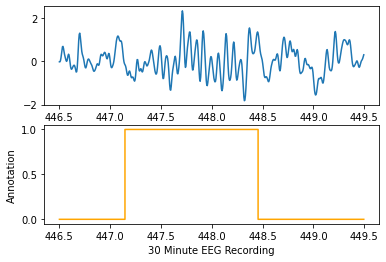

In [20]:
ig = plt.figure(figsize=(15,4))

# Obtain the time axis for the signal. We are given that fs = 100Hz
max_time = total_samples / sampling_freq
t = np.arange(0, max_time, 1/sampling_freq)

# Plot the raw signal against the time
fig, axs = plt.subplots(2)
plt.xlabel("Time (Seconds)")
plt.ylabel("Annotation")
plt.xlabel("30 Minute EEG Recording")
axs[0].plot(t[89300:89900],y[89300:89900])
axs[1].step(t[89300:89900],annot[89300:89900],'orange',where='pre')
plt.show()

# **Create sliding window for possibility calculation
* Spindle detection equals 1
* Non spindle equals 0

In [21]:
i=0
z=0
sum = 0
possibility = np.zeros(36005)
while i<360050:
    x=i
    for x in range(i,100+i):
        sum = sum + data['annotation'][x]
    avg = sum/100
    avg = round(avg,2)
    possibility[z] = avg
    sum = 0
    z = z+1
    i = i+10

In [22]:
z=0
w=0
x=0
for i in range(36005):
    if possibility[i]==1:
        z=z+1
    elif possibility[i]==0:
        w = w + 1
    else: x=x+1
print(z,w,x)

891 33230 1884


<Figure size 1080x288 with 0 Axes>

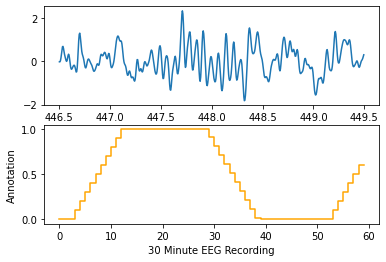

In [23]:
ig = plt.figure(figsize=(15,4))

# Obtain the time axis for the signal. We are given that fs = 100Hz
max_time = total_samples / sampling_freq
t = np.arange(0, max_time, 1/sampling_freq)

# Plot the raw signal against the time
fig, axs = plt.subplots(2)
plt.xlabel("Time (Seconds)")
plt.ylabel("Annotation")
plt.xlabel("30 Minute EEG Recording")
axs[0].plot(t[89300:89900],y[89300:89900])
axs[1].step(possibility[8930:8990],'orange',where='pre')
plt.show()

In [24]:
possibility[20:50]

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.2 , 0.3 , 0.4 , 0.5 ,
       0.6 , 0.7 , 0.8 , 0.9 , 1.  , 1.  , 1.  , 0.98, 0.88, 0.78, 0.68,
       0.58, 0.48, 0.38, 0.28, 0.18, 0.08, 0.  , 0.  ])

In [25]:
for i in range(len(possibility)):
    if possibility[i]>=0.5:
        possibility[i] = 1
    else: possibility[i] = 0

In [26]:
possibility[20:50]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.])

In [27]:
z=0
w=0
x=0
for i in range(36005):
    if possibility[i]==1:
        z=z+1
    elif possibility[i]==0:
        w = w + 1
    else: x=x+1
print(z,w,x)

1899 34106 0


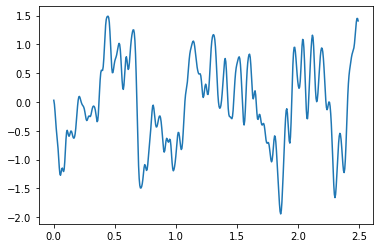

In [28]:
max_time = 500 / sampling_freq
t = np.arange(0, max_time, 1/sampling_freq)

plt.plot(t,y[2500:3000])
plt.show()

In [29]:
train = np.empty((36005,100),float)
shape(train)

(36005, 100)

In [30]:
m=0
z=0
n=0
while m<360050:
    v=m
    for v in range(m,100+m):
        train[z][n] = y[v]
        n = n + 1
    z = z + 1
    m = m + 10
    n = 0

In [31]:
#possibility = to_categorical(possibility)

In [32]:
shape(possibility)

(36005,)

In [33]:
possibility[20]

0.0

In [34]:
x_train, x_test, y_train, y_test = train_test_split(train, possibility, train_size = 0.7,shuffle = False)

In [35]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [36]:
x_train.shape[1]

100

In [37]:
model = Sequential()
input_shape=(x_train.shape[1], 1)

model.add(Conv1D(64, kernel_size=3,strides = 1,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.25))

model.add(Conv1D(128,kernel_size=3,strides = 1,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.25))

model.add(Conv1D(256,kernel_size=3,strides = 1,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.25))


model.add(Flatten()
         )

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))


model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 100, 64)           256       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 64)           256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 128)           24704     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 128)           512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 128)           0

In [38]:
opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='binary_crossentropy',metrics = ['accuracy'])

In [39]:
history = model.fit(x_train, y_train, epochs=10, batch_size=256, validation_data=(x_test, y_test))

Epoch 1/10
99/99 [==============================] - 16s 159ms/step - loss: 0.2202 - accuracy: 0.9398 - val_loss: 4.2667 - val_accuracy: 0.0572
Epoch 2/10
99/99 [==============================] - 17s 175ms/step - loss: 0.1455 - accuracy: 0.9554 - val_loss: 1.3378 - val_accuracy: 0.5024
Epoch 3/10
99/99 [==============================] - 21s 210ms/step - loss: 0.1223 - accuracy: 0.9632 - val_loss: 0.2543 - val_accuracy: 0.8929
Epoch 4/10
99/99 [==============================] - 22s 218ms/step - loss: 0.1126 - accuracy: 0.9652 - val_loss: 0.1472 - val_accuracy: 0.9553
Epoch 5/10
99/99 [==============================] - 19s 194ms/step - loss: 0.1089 - accuracy: 0.9670 - val_loss: 0.1387 - val_accuracy: 0.9559
Epoch 6/10
99/99 [==============================] - 19s 193ms/step - loss: 0.1049 - accuracy: 0.9678 - val_loss: 0.1299 - val_accuracy: 0.9585
Epoch 7/10
99/99 [==============================] - 19s 190ms/step - loss: 0.1011 - accuracy: 0.9691 - val_loss: 0.1275 - val_accuracy: 0.9560

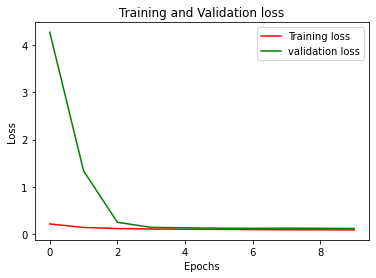

In [40]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,10)
plt.plot(epochs, loss_train, 'r', label='Training loss')
plt.plot(epochs, loss_val, color='g', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

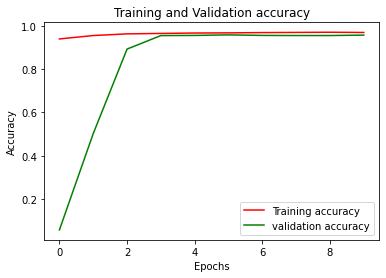

In [41]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(0,10)
plt.plot(epochs, loss_train, 'r', label='Training accuracy')
plt.plot(epochs, loss_val, color='g', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [42]:
out = model.predict(x_test)

In [43]:
out[510:530]

array([[0.07468963],
       [0.30452222],
       [0.26019874],
       [0.4907695 ],
       [0.9970232 ],
       [0.9323051 ],
       [0.99406135],
       [0.9740766 ],
       [0.9713978 ],
       [0.9871407 ],
       [0.99152035],
       [0.99661314],
       [0.9916234 ],
       [0.8960004 ],
       [0.7299558 ],
       [0.1144737 ],
       [0.07779357],
       [0.02681997],
       [0.02428269],
       [0.00838873]], dtype=float32)

In [44]:
predict = np.empty(len(out))
for i in range(len(out)):
    if out[i]>=0.6 : predict[i] = 1
    else: predict[i] = 0

In [45]:
predict[510:530]

array([0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0.])

In [46]:
y_test[510:530]

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [47]:
max_time = 1000 / sampling_freq
t = np.arange(0, max_time, 1/sampling_freq)

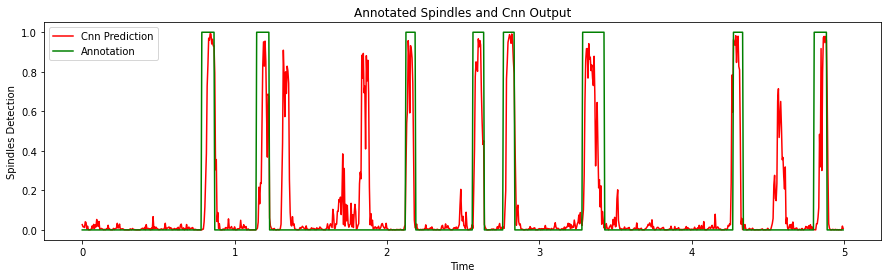

In [48]:
ig = plt.figure(figsize=(15,4))

plt.plot(t, out[4000:5000], 'r',label = "Cnn Prediction")
plt.plot(t,y_test[4000:5000],'g',label = "Annotation")
plt.title('Annotated Spindles and Cnn Output')
plt.xlabel('Time')
plt.ylabel('Spindles Detection')
plt.legend()
plt.show()

In [49]:
import sklearn
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test, np.rint(out)).ravel()

In [50]:
tp , fp , tn , fn

(378, 220, 9964, 240)

In [51]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1score = 2*(precision*recall/(precision+recall))
print(precision,recall,f1score)

0.6321070234113713 0.6116504854368932 0.6217105263157895


In [52]:
#from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score, confusion_matrix
#print(precision_score(y_test, predict , average="macro"))
#print(recall_score(y_test, predict , average="macro"))
#print(f1_score(y_test, predict , average="macro"))
#print(accuracy_score(y_test, predict))

In [53]:
filepath1 = "C:\\Users\\Nikolas Theol\\Desktop\\ECE\\Διπλωματικη\\Spindles"
edf_file1 = "excerpt5.txt"
total_filepath1 = filepath1 + "\\" + edf_file1
ed = pd.read_csv(total_filepath1, sep='\n')
    
spindle_marks1 = "Automatic_detection_excerpt5.txt"
#spindle_marks2 = input("Enter name of the .txt file containing the detected spindles: ")

temp1 = filepath + "\\" + spindle_marks1
expert_spindles1 = pd.read_csv(temp1, sep='\t').reset_index()
expert_spindles1.columns = ['time', 'duration']

#temp2 = filepath + "\\" + spindle_marks2
#expert_spindles2 = pd.read_csv(temp2, sep='\t').reset_index()
#expert_spindles2.columns = ['time', 'duration']

In [54]:
filt = butter_bandpass_filter(ed, 1, 30, sampling_freq, order=6)
filt = filt.reshape(filt.shape[0])
shape(filt)

(360000,)

In [55]:
mean1 = statistics.mean(filt)

In [56]:
stdev1 = statistics.stdev(filt)

In [57]:
for i in range(len(filt)):
    filt[i] = (filt[i]-mean1)/stdev1

In [58]:
pred = np.empty((35991,100),float)
shape(pred)

(35991, 100)

In [59]:
m=0
z=0
n=0
while m<359910:
    v=m
    for v in range(m,100+m):
        pred[z][n] = filt[v]
        n = n + 1
    z = z + 1
    m = m + 10
    n = 0

In [60]:
data1 = pd.DataFrame(data = filt)
time1 = []
temp1 = 0
for i in range(360000):  
    time1.insert(i,temp1)
    temp1 = temp1 + 0.005

In [61]:
data1['time'] = time1
data1.columns = ['μV', 'time']

In [62]:
data1

,μV,time
0,-0.099531,0.000
1,0.129867,0.005
2,0.298196,0.010
3,0.408016,0.015
4,0.411094,0.020
...,...,...
359995,-1.081268,1799.975
359996,-1.096661,1799.980
359997,-1.110520,1799.985
359998,-1.149008,1799.990


In [63]:
microevents_start = expert_spindles1['time']
microevents_duration = expert_spindles1['duration']
microevents_end = np.sum([microevents_start, microevents_duration], axis=0)
d = {'start':microevents_start, 'end':microevents_end}
spindle_events1 = pd.DataFrame(data=d)
spindle_events1

,start,end
0,13.725,14.555
1,19.950,20.855
2,26.250,27.055
3,30.350,32.555
4,33.150,33.755
...,...,...
79,1675.850,1676.855
80,1681.650,1682.755
81,1693.750,1694.855
82,1705.350,1706.155


In [64]:
col = list(data1['time'])
col1 = list(spindle_events1['start'])
col2 = list(spindle_events1['end'])
for i in range(360000):
    col[i] = round(col[i],3)

for i in range(84):
    col1[i] = round(col1[i],3)
    col2[i] = round(col2[i],3)

In [65]:
annot1 = [0]*360000
flag = 0

for i in range(360000):
    for j in range(84):
        if col[i] == col1[j] or flag == 1:
            annot1[i] = 1
            flag = 1
            if col[i] == col2[j]:
                flag = 0

In [66]:
annot1 = np.array(annot1)
x=0
r=0
for i in range(len(annot1)):
    if annot1[i] == 0:
        x=x+1
    elif annot1[i]== 1 :
        r = r+1
print(x,r)
len(annot1)

345195 14805


360000

In [67]:
annotation = pd.DataFrame(data = annot1)
data1['annotation'] = annotation
data1.columns = ['μV', 'time','annotation']

In [68]:
data1.loc[48130:48140]

,μV,time,annotation
48130,0.220189,240.650,0
48131,0.265860,240.655,0
48132,0.309485,240.660,0
48133,0.375172,240.665,0
48134,0.386979,240.670,0
48135,0.372607,240.675,0
48136,0.383895,240.680,0
48137,0.294086,240.685,0
48138,0.183240,240.690,0
48139,0.028252,240.695,0


In [69]:
i=0
z=0
sum = 0
possibility1 = np.zeros(35991)
while i<359910:
    x=i
    for x in range(i,100+i):
        sum = sum + data1['annotation'][x]
    avg = sum/100
    avg = round(avg,2)
    possibility1[z] = avg
    sum = 0
    z = z+1
    i = i+10

In [70]:
for i in range(len(possibility1)):
    if possibility1[i]>0.5:
        possibility1[i] = 1
    else: possibility1[i] = 0

In [71]:
h=0
o=0
for i in range(len(possibility1)):
    if possibility1[i]==1:
        h=h+1
    else: o=o+1
print(h,o)

1464 34527


In [72]:
pred = pred.reshape(pred.shape[0],pred.shape[1], 1)


In [73]:
out1 = model.predict(pred)

In [74]:
max_time = 1000 / sampling_freq
t = np.arange(0, max_time, 1/sampling_freq)

<Figure size 1080x288 with 0 Axes>

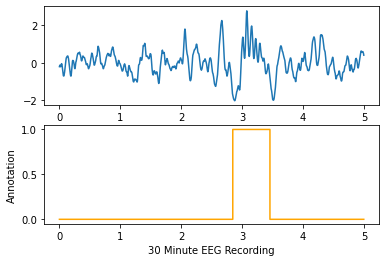

In [75]:
ig = plt.figure(figsize=(15,4))
max_time = 1000 / sampling_freq
t = np.arange(0, max_time, 1/sampling_freq)
fig, axs = plt.subplots(2)
plt.xlabel("Time (Seconds)")
plt.ylabel("Annotation")
plt.xlabel("30 Minute EEG Recording")
axs[0].plot(t,filt[130000:131000])
axs[1].step(t,annot1[130000:131000],'orange',where='pre')
plt.show()

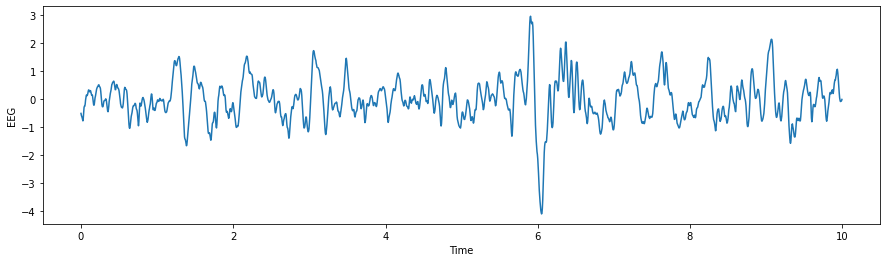

In [76]:
ig = plt.figure(figsize=(15,4))
max_time = 2000 / sampling_freq
t = np.arange(0, max_time, 1/sampling_freq)

plt.plot(t,filt[13000:15000])
plt.xlabel('Time')
plt.ylabel('EEG')

plt.show()

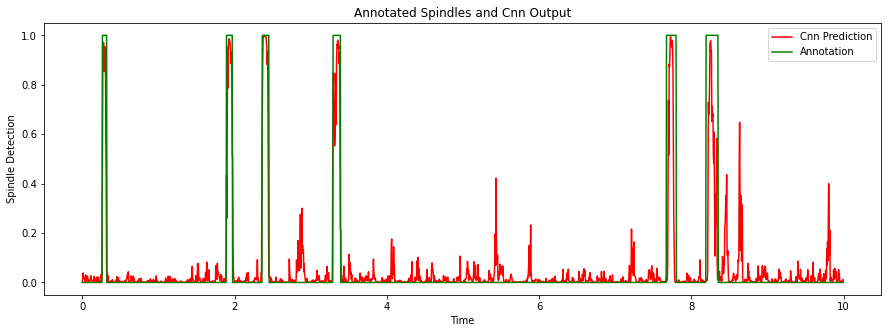

In [77]:
ig = plt.figure(figsize=(15,5))
max_time = 2000 / sampling_freq
t = np.arange(0, max_time, 1/sampling_freq)
plt.plot(t, out1[13000:15000], 'r',label = "Cnn Prediction")
plt.plot(t,possibility1[13000:15000],'g',label = "Annotation" )
plt.title('Annotated Spindles and Cnn Output')
plt.xlabel('Time')
plt.ylabel('Spindle Detection')
plt.legend()
plt.show()

In [78]:
predict1 = np.empty(len(out1))
for i in range(len(out1)):
    if out1[i]>=0.6 : predict1[i] = 1
    else: predict1[i] = 0

In [79]:
from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score, confusion_matrix
print(precision_score(possibility1, predict1))
print(recall_score(possibility1, predict1))
print(f1_score(possibility1, predict1))
print(accuracy_score(possibility1, predict1))

0.7239858906525574
0.5607923497267759
0.6320246343341032
0.9734378038954183


In [80]:
import sklearn
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(possibility1, predict1).ravel()
tp, fp, tn, fn

(821, 313, 34214, 643)

In [81]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1score = 2*(precision*recall/(precision+recall))
print(precision,recall,f1score)

0.7239858906525574 0.5607923497267759 0.6320246343341032
